# Importacion

In [4]:
import numpy as np
import pandas as pd
import os 
import sys
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
import optuna
import optuna.visualization as vis
from catboost import CatBoostClassifier

from Classes.dataframe_manager import DataFrameManager

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Leer datos

In [5]:
# Asegurar que el directorio del proyecto esté en sys.path
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.append(project_root)

In [6]:
manager = DataFrameManager()
manager.load_multiple([
    'features_test_ord',
    'target_test_ord',
    'features_upsampled_ord',
    'features_valid_ord',
    'target_upsampled_ord',
    'target_valid_ord'
])

DataFrame 'features_test_ord' cargado exitosamente en el administrador.
DataFrame 'target_test_ord' cargado exitosamente en el administrador.
DataFrame 'features_upsampled_ord' cargado exitosamente en el administrador.
DataFrame 'features_valid_ord' cargado exitosamente en el administrador.
DataFrame 'target_upsampled_ord' cargado exitosamente en el administrador.
DataFrame 'target_valid_ord' cargado exitosamente en el administrador.


In [9]:
# Asignar cada dataframe a una variable con su nombre para utilizarla en el notebook

features_test_ord = manager.get_dataframe('features_test_ord')
target_test_ord = manager.get_dataframe('target_test_ord')
features_upsampled_ord = manager.get_dataframe('features_upsampled_ord')
target_upsampled_ord = manager.get_dataframe('target_upsampled_ord')

# Prueba del modelo

In [10]:
# Crear el modelo de CatBoost
model_cat = CatBoostClassifier(
    learning_rate=0.02,
    depth=7,
    random_seed=12345,
    iterations=500,
    loss_function='Logloss',  # Pérdida adecuada para clasificación binaria
    eval_metric='AUC',        # Métrica de evaluación correcta
    verbose=50
)

In [11]:
# Entrenar el modelo
model_cat.fit(features_upsampled_ord, target_upsampled_ord, cat_features=None)

# Obtener probabilidades sobre el conjunto de entrenamiento
pred_test_proba = model_cat.predict_proba(features_test_ord)[:, 1]
pred_test = model_cat.predict(features_test_ord)

# Calcular la curva ROC
fpr_cat, tpr_cat, thresholds_cat = roc_curve(
    target_test_ord, pred_test_proba)

# Calcular AUC-ROC
auc_score_cat = roc_auc_score(target_test_ord, pred_test_proba)
acc_score_cat = accuracy_score(target_test_ord, pred_test)

print()
print(f"AUC-ROC score en el conjunto de prueba: {auc_score_cat:.4f}")
print(f"Accuracy score en el conjunto de prueba: {acc_score_cat:.4f}")


0:	total: 164ms	remaining: 1m 21s
50:	total: 391ms	remaining: 3.44s
100:	total: 632ms	remaining: 2.5s
150:	total: 939ms	remaining: 2.17s
200:	total: 1.2s	remaining: 1.78s
250:	total: 1.45s	remaining: 1.44s
300:	total: 1.72s	remaining: 1.13s
350:	total: 2s	remaining: 848ms
400:	total: 2.28s	remaining: 562ms
450:	total: 2.54s	remaining: 276ms
499:	total: 2.83s	remaining: 0us

AUC-ROC score en el conjunto de prueba: 0.8180
Accuracy score en el conjunto de prueba: 0.9216


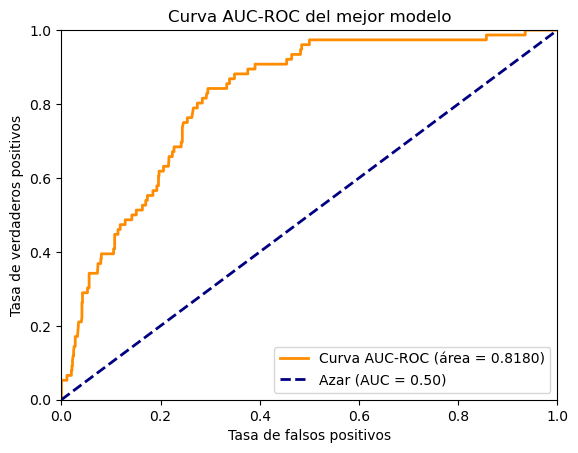

In [15]:
# Gráfica de la curva AUC-ROC
    
plt.figure()
plt.plot(fpr_cat, tpr_cat, color='darkorange', lw=2, label=f'Curva AUC-ROC (área = {auc_score_cat:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar (AUC = 0.50)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva AUC-ROC del mejor modelo')
plt.legend(loc='lower right')
plt.show()